# BNN using MCMC for predicting Band Gaps 

In [1]:
from pyro.infer import MCMC, NUTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from BNN_basic_model import BayesianNN

from sklearn.preprocessing import StandardScaler
import torch.distributions as dist

# Use predictive distribution
from pyro.infer import Predictive





### Read the data 

In [2]:
df_mp = pd.read_csv('/home/april-ai/Desktop/UQ/MP_Data/materials_data_10k_cleaned.csv')

### Train-test split

In [3]:
y = df_mp['band_gap'].values
excluded = ["material_id", "composition", "formula_pretty", "symmetry", "structure"]
X = df_mp.drop(excluded, axis=1)

#print("There are {} possible descriptors:\n\n{}".format(X.shape[1], X.columns.values))


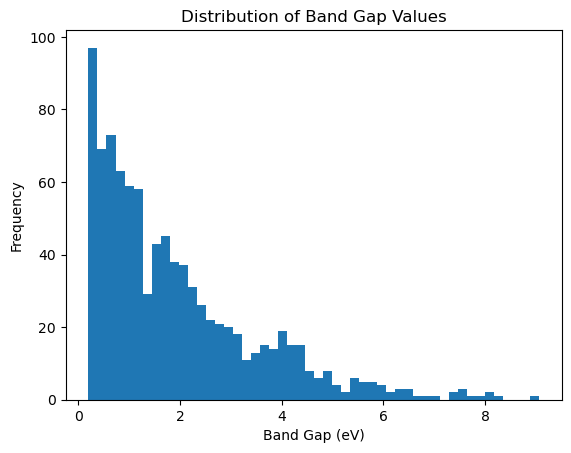

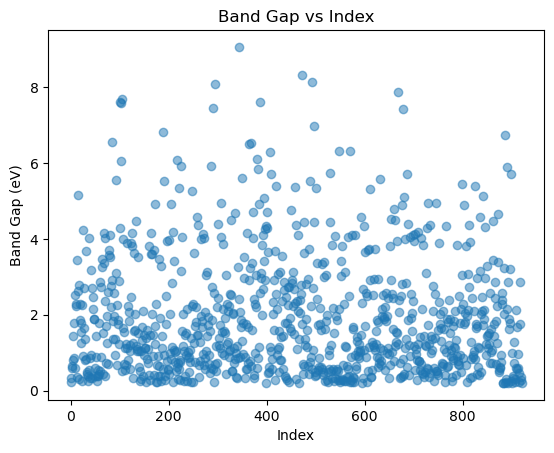

In [31]:
#visualize the distrubution of  the band gap data 

plt.hist(y, bins=50)
plt.xlabel('Band Gap (eV)')
plt.ylabel('Frequency')
plt.title('Distribution of Band Gap Values')
plt.show()

#visualise the bannd gap vs index 
plt.scatter(range(len(y)), y, alpha=0.5)
plt.xlabel('Index')
plt.ylabel('Band Gap (eV)')
plt.title('Band Gap vs Index')
plt.show()

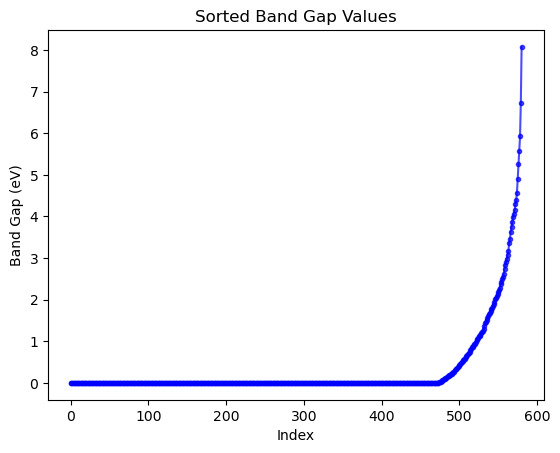

In [4]:
#visualise sorted band gap values
sorted_y = np.sort(y)
plt.plot(sorted_y[: : 10], marker='o', markersize=3, linestyle='-', color='blue', alpha=0.7)
plt.xlabel('Index')
plt.ylabel('Band Gap (eV)')
plt.title('Sorted Band Gap Values')
plt.show()

In [5]:
#Train tes split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Data preprocessing

In [6]:

# Drop non-numeric / irrelevant fields
non_feature_cols = [
    "sites", "composition", "formula_pretty", "structure", "symmetry",
    "material_id"
]
df = df_mp.drop(columns=non_feature_cols, errors='ignore')
df = df.dropna(subset=["band_gap"])

# Save original indices
original_indices = np.arange(len(df))

# Split first — before scaling — and keep track of original indices
X_raw = df.drop(columns=["band_gap"])
y_raw = df["band_gap"]

X_train_raw, X_test_raw, y_train_raw, y_test_raw, idx_train, idx_test = train_test_split(
    X_raw, y_raw, original_indices, test_size=0.2, random_state=42
)


In [7]:
# Normalise training data
scaler_x = StandardScaler()
scaler_y = StandardScaler()


X_train = scaler_x.fit_transform(X_train_raw) #computes mean and std from training data and scales it
X_test = scaler_x.transform(X_test_raw) #uses the same mean and std to scale test data

y_train = scaler_y.fit_transform(y_train_raw.values.reshape(-1, 1)).ravel()
y_test = scaler_y.transform(y_test_raw.values.reshape(-1, 1)).ravel() #ravel() flattens the output back to 1D, which is typically needed for PyTorch models expecting targets as flat vectors.

# Convert to Pytorch tensors
#C onverts the NumPy arrays into torch.tensor objects, which are the format needed for training/testing the BNN in PyTorch.
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

In [9]:
print(len(X_train), len(X_test))

4643 1161


### MCMC Sample and run the model 

In [12]:
import importlib
import BNN_model
importlib.reload(BNN_model)
from BNN_model import BayesianNN

In [13]:
model = BayesianNN(input_dim=X_train.shape[1])  # Initialise BayesianNN model

nuts_kernel = NUTS(model)  # No-U-Turn Sampler — a smart version of Hamiltonian Monte Carlo (HMC) that avoids manually setting path lengths
#=> performs gradient-based MCMC to sample from the posterior distribution over the model parameters, given data.

#Run MCMC 
mcmc = MCMC(nuts_kernel, num_samples=300, warmup_steps=200)
mcmc.run(X_train_tensor, y_train_tensor) #After: 300 samples from the posterior distribution over the weights and biases of the BNN

posterior_samples = mcmc.get_samples() # dictionary of sampled model parameters (e.g., weights, biases)


Sample: 100%|██████████| 500/500 [50:51,  6.10s/it, step size=9.33e-04, acc. prob=0.741]


### Make predictions 

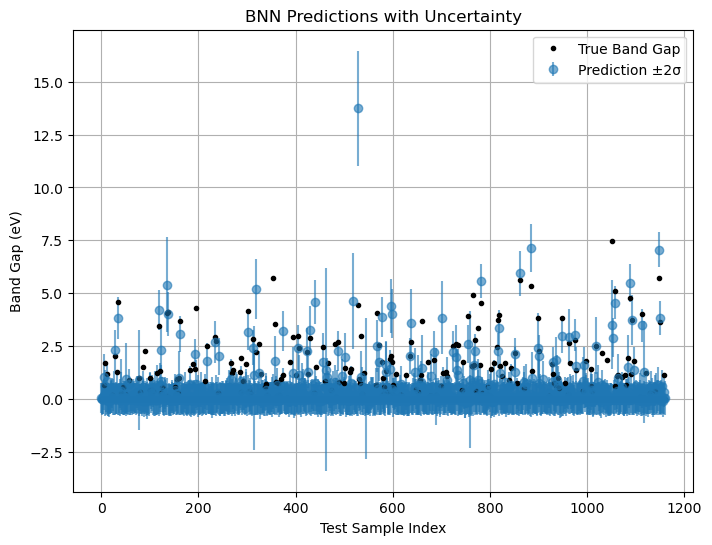

In [14]:
#getting predictions from the posterior 
predictive = Predictive(model, posterior_samples, return_sites=["obs"]) #Predictive in Pyro uses sample from posterior to generate predictiosn 
#=> return predictions at the "obs" site in the model, which corresponds to the observed outputs (e.g., target band gaps).

#pass X_test_tensor (test inputs as a PyTorch tensor) to the predictive object.
#=> Each row in preds corresponds to predictions from one set of posterior parameters.
preds = predictive(X_test_tensor)["obs"]  # output shape: [num_samples, num_test_points]

mean_pred = preds.mean(dim=0).numpy() #average over the posterior predictive samples — predictive mean, best estimate of the output
std_pred = preds.std(dim=0).numpy() # standard deviation over the predictive samples — epistemic uncertainty

# Inverse-transform band gaps
#converts the predicted means back to the original scale (eV) from being scaled using StandardScaler
mean_pred_actual = scaler_y.inverse_transform(mean_pred.reshape(-1, 1)).ravel()

#adjust the predicted uncertainty to match the units of the original data.
std_pred_actual = std_pred * scaler_y.scale_[0]  # std scales linearly

#convert the standardized y_test targets back to the original scale, for comparison with predictions.
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()

# Plot with confidence interval
plt.figure(figsize=(8, 6))
plt.errorbar(np.arange(len(mean_pred_actual)), mean_pred_actual, yerr=2*std_pred_actual, fmt='o', label="Prediction ±2σ", alpha=0.6)
plt.plot(np.arange(len(y_test_actual)), y_test_actual, 'k.', label="True Band Gap")
plt.xlabel("Test Sample Index")
plt.ylabel("Band Gap (eV)")
plt.title("BNN Predictions with Uncertainty")
plt.legend()
plt.grid(True)
plt.show()


#### Compute log-likelihood

In [15]:
test_preds = predictive(X_test_tensor)["obs"]  # shape: [num_samples, num_test_points]

# Mean and std from posterior predictive samples
mean_pred = test_preds.mean(dim=0)
std_pred = test_preds.std(dim=0) + 1e-6  # avoid log(0)

# Assume Gaussian predictive distribution
likelihood = dist.Normal(mean_pred, std_pred)

# Convert true y_test values (already standardized) to tensor
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Compute log-probability of true values under the predictive distribution
log_probs = likelihood.log_prob(y_test_tensor)  # shape: [num_test_points]

# Compute total and average log-likelihood
log_likelihood_total = log_probs.sum().item()
log_likelihood_avg = log_probs.mean().item()
nll = -log_likelihood_total
nll_avg = -log_likelihood_avg

print(f"Total Log-Likelihood (Test): {log_likelihood_total:.2f}")
print(f"Average Log-Likelihood per Sample: {log_likelihood_avg:.4f}")
print(f"Negative Log-Likelihood (NLL): {nll:.2f}")
print(f"Average NLL per Sample: {nll_avg:.4f}")


Total Log-Likelihood (Test): -771.96
Average Log-Likelihood per Sample: -0.6649
Negative Log-Likelihood (NLL): 771.96
Average NLL per Sample: 0.6649


In [16]:
train_nlls = []
test_nlls = []

# Loop over posterior samples
num_samples = list(posterior_samples.values())[0].shape[0]  # Get num posterior samples
for i in range(num_samples):
    # Make a model using only one sample
    single_sample = {k: v[i:i+1] for k, v in posterior_samples.items()}  # slice keeps dim
    predictive = Predictive(model, single_sample, return_sites=["obs"])
    
    # --- TRAIN ---
    train_pred = predictive(X_train_tensor)["obs"].squeeze()
    train_std = train_pred.std().item() + 1e-6
    train_mean = train_pred.mean().item()
    likelihood_train = dist.Normal(train_mean, train_std)
    log_probs_train = likelihood_train.log_prob(y_train_tensor)
    nll_train = -log_probs_train.mean().item()
    train_nlls.append(nll_train)
    
    # --- TEST ---
    test_pred = predictive(X_test_tensor)["obs"].squeeze()
    test_std = test_pred.std().item() + 1e-6
    test_mean = test_pred.mean().item()
    likelihood_test = dist.Normal(test_mean, test_std)
    log_probs_test = likelihood_test.log_prob(y_test_tensor)
    nll_test = -log_probs_test.mean().item()
    test_nlls.append(nll_test)


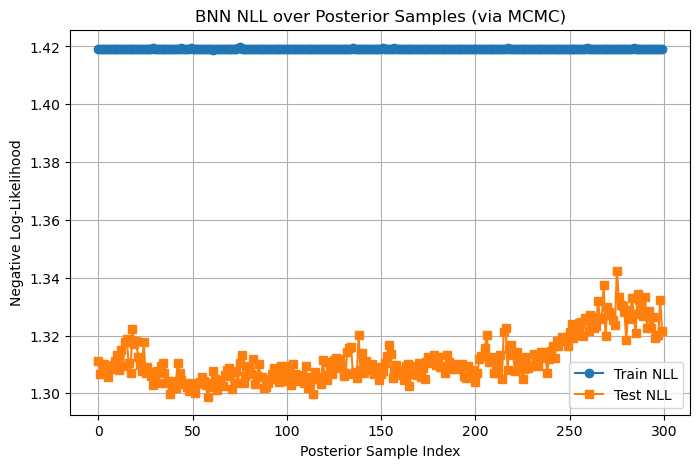

In [17]:
plt.figure(figsize=(8, 5))
plt.plot(train_nlls, label="Train NLL", marker='o')
plt.plot(test_nlls, label="Test NLL", marker='s')
plt.xlabel("Posterior Sample Index")
plt.ylabel("Negative Log-Likelihood")
plt.title("BNN NLL over Posterior Samples (via MCMC)")
plt.legend()
plt.grid(True)
plt.show()


/tmp/ipykernel_204530/337024749.py:4: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  std_pred_train = preds_train.std(dim=0).numpy()


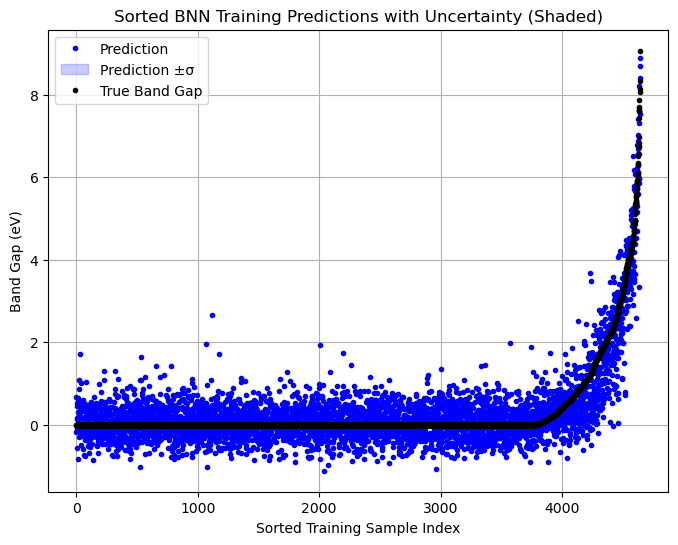

In [18]:
# Get posterior predictions on training data
preds_train = predictive(X_train_tensor)["obs"]
mean_pred_train = preds_train.mean(dim=0).numpy()
std_pred_train = preds_train.std(dim=0).numpy()

# Inverse-transform
mean_pred_train_actual = scaler_y.inverse_transform(mean_pred_train.reshape(-1, 1)).ravel()
std_pred_train_actual = std_pred_train * scaler_y.scale_[0]
y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1)).ravel()

# Sort by true values for plotting
sorted_indices = np.argsort(y_train_actual)
sorted_mean_pred_actual = mean_pred_train_actual[sorted_indices]
sorted_std_pred_actual = std_pred_train_actual[sorted_indices]
sorted_y_train_actual = y_train_actual[sorted_indices]

# Compute bounds for uncertainty region (±1σ or use ±2σ if preferred)
x = np.arange(len(sorted_mean_pred_actual))
upper = sorted_mean_pred_actual + sorted_std_pred_actual
lower = sorted_mean_pred_actual - sorted_std_pred_actual

# Plot
plt.figure(figsize=(8, 6))
plt.plot(x, sorted_mean_pred_actual, 'b.', label="Prediction")
plt.fill_between(x, lower, upper, color='blue', alpha=0.2, label="Prediction ±σ")
plt.plot(x, sorted_y_train_actual, 'k.', label="True Band Gap")
plt.xlabel("Sorted Training Sample Index")
plt.ylabel("Band Gap (eV)")
plt.title("Sorted BNN Training Predictions with Uncertainty (Shaded)")
plt.legend()
plt.grid(True)
plt.show()


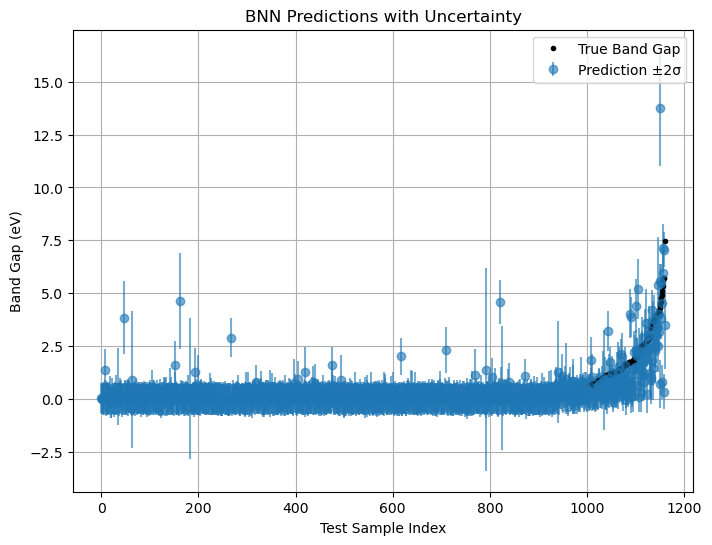

In [19]:
sorted_indices = np.argsort(y_test_actual)
sorted_y_test_actual = y_test_actual[sorted_indices]
sorted_mean_pred_actual = mean_pred_actual[sorted_indices]
sorted_std_pred_actual = std_pred_actual[sorted_indices]
# Plot with confidence interval
plt.figure(figsize=(8, 6))
plt.errorbar(np.arange(len(sorted_mean_pred_actual)), sorted_mean_pred_actual, yerr=2*sorted_std_pred_actual, fmt='o', label="Prediction ±2σ", alpha=0.6)
plt.plot(np.arange(len(sorted_y_test_actual)), sorted_y_test_actual, 'k.', label="True Band Gap")
plt.xlabel("Test Sample Index")
plt.ylabel("Band Gap (eV)")
plt.title("BNN Predictions with Uncertainty")
plt.legend()
plt.grid(True)
plt.show()

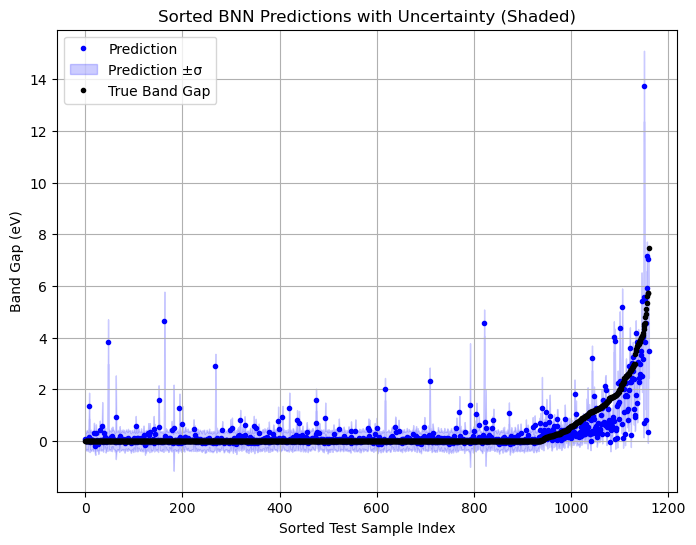

In [20]:
x = np.arange(len(sorted_mean_pred_actual))
upper = sorted_mean_pred_actual + sorted_std_pred_actual
lower = sorted_mean_pred_actual - sorted_std_pred_actual

plt.figure(figsize=(8, 6))
plt.plot(x, sorted_mean_pred_actual, 'b.', label="Prediction")
plt.fill_between(x, lower, upper, color='blue', alpha=0.2, label="Prediction ±σ")
plt.plot(x, sorted_y_test_actual, 'k.', label="True Band Gap")
plt.xlabel("Sorted Test Sample Index")
plt.ylabel("Band Gap (eV)")
plt.title("Sorted BNN Predictions with Uncertainty (Shaded)")
plt.legend()
plt.grid(True)
plt.show()

In [21]:
#get information about outliers 
outliers = np.abs(sorted_mean_pred_actual - sorted_y_test_actual) > 1.5 # Define outliers as those with a difference greater than 0.2 eV
outlier_indices = np.where(outliers)[0]
sorted_y_test_actual = y_test_actual[sorted_indices]
sorted_mean_pred_actual = mean_pred_actual[sorted_indices]
print("Outlier Indices:", outlier_indices)
print("Outlier Predictions:", sorted_mean_pred_actual[outlier_indices])
print("Outlier True Values:", sorted_y_test_actual[outlier_indices])


Outlier Indices: [  47  151  163  268  475  617  709  821 1043 1081 1088 1090 1091 1095
 1100 1104 1105 1107 1111 1118 1123 1129 1131 1132 1134 1136 1146 1149
 1150 1154 1156 1158 1160]
Outlier Predictions: [ 3.8447628   1.5863844   4.6420555   2.9018376   1.5917854   2.0073757
  2.3022425   4.569493    3.210779   -0.03450997  4.0370784   3.8648012
  0.08007801  0.12058942  4.378806    0.65187865  5.1944447   0.10700968
  0.26477113  0.7885295   0.20923081  1.2320368   1.010384    0.91448456
  1.7708037   1.4818724   2.5096912   0.70975167 13.73801     0.8151277
  7.1470194   0.33537963  3.4964206 ]
Outlier True Values: [0.     0.     0.     0.     0.     0.     0.     0.     1.1337 1.6697
 1.7265 1.7516 1.7589 1.8242 2.0151 2.1595 2.1977 2.2712 2.4349 2.575
 2.736  2.92   2.9859 3.3753 3.56   3.6753 4.0739 4.3169 4.4529 4.9116
 5.3252 5.7126 7.4639]


In [22]:
outlier_test_indices = sorted_indices[outlier_indices]

In [23]:
# Map test index to original DataFrame index
outlier_original_indices = idx_test[outlier_test_indices]


#### Plot shading ±1 standard deviation (σ) (68% confidence)

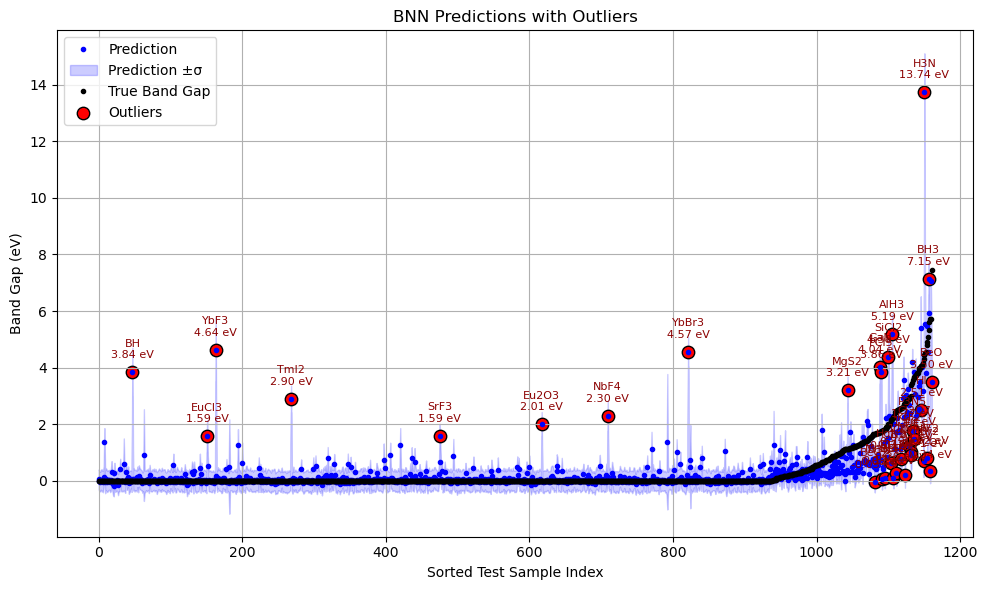

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Map sorted → test → original index
outlier_test_indices = sorted_indices[outlier_indices]
outlier_original_indices = idx_test[outlier_test_indices]

# Get pretty formulas from original dataset
formulas = df_mp.iloc[outlier_original_indices]["formula_pretty"].values

# Plot predictions and uncertainty
x = np.arange(len(sorted_mean_pred_actual))
errors = np.abs(sorted_mean_pred_actual - sorted_y_test_actual)
outlier_mask = errors > 1.5
outlier_indices = np.where(outlier_mask)[0]
outlier_preds = sorted_mean_pred_actual[outlier_indices]

plt.figure(figsize=(10, 6))
plt.plot(x, sorted_mean_pred_actual, 'b.', label="Prediction")
plt.fill_between(x, lower, upper, color='blue', alpha=0.2, label="Prediction ±σ")
plt.plot(x, sorted_y_test_actual, 'k.', label="True Band Gap")
plt.scatter(x[outlier_indices], outlier_preds, color='red', edgecolor='black', s=80, label='Outliers')

# Annotate each outlier with formula and predicted band gap
for i, idx in enumerate(outlier_indices):
    pred_val = sorted_mean_pred_actual[idx]
    formula = formulas[i]
    plt.annotate(
        f"{formula}\n{pred_val:.2f} eV",
        (x[idx], pred_val),
        textcoords="offset points",
        xytext=(0, 10),
        ha='center',
        fontsize=8,
        color='darkred'
    )

# Formatting
plt.xlabel("Sorted Test Sample Index")
plt.ylabel("Band Gap (eV)")
plt.title("BNN Predictions with Outliers")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [25]:
#Compute absolute error and define outliers
errors = np.abs(sorted_mean_pred_actual - sorted_y_test_actual)
outlier_mask = errors > 1.5  # Define your outlier threshold here
outlier_indices_sorted = np.where(outlier_mask)[0]

# Map sorted index → test index → original dataset index
outlier_test_indices = sorted_indices[outlier_indices_sorted]
outlier_original_indices = idx_test[outlier_test_indices]

#Extract info from the original DataFrame
compositions = df_mp.iloc[outlier_original_indices]["formula_pretty"].values
true_bandgaps = sorted_y_test_actual[outlier_indices_sorted]
predicted_bandgaps = sorted_mean_pred_actual[outlier_indices_sorted]

#Build the summary table
outliers_df = pd.DataFrame({
    "outlier_index": outlier_indices,
    "original_index": outlier_original_indices,
    "formula": compositions,
    "true_band_gap": true_bandgaps,
    "predicted_band_gap": predicted_bandgaps, 
    "absolute error": predicted_bandgaps - true_bandgaps

})


print(outliers_df.sort_values(by="true_band_gap"))


    outlier_index  original_index formula  true_band_gap  predicted_band_gap  \
0              47            4091      BH         0.0000            3.844763   
1             151            1471   EuCl3         0.0000            1.586384   
2             163            5167    YbF3         0.0000            4.642056   
3             268            3307    TmI2         0.0000            2.901838   
4             475            3433    SrF3         0.0000            1.591785   
5             617             401   Eu2O3         0.0000            2.007376   
6             709            3707    NbF4         0.0000            2.302243   
7             821            1219   YbBr3         0.0000            4.569493   
8            1043             297    MgS2         1.1337            3.210779   
9            1081            5678    BeC2         1.6697           -0.034510   
10           1088             996     GaN         1.7265            4.037078   
11           1090             611    PCl

#### Plot shading 95% confidence interval 

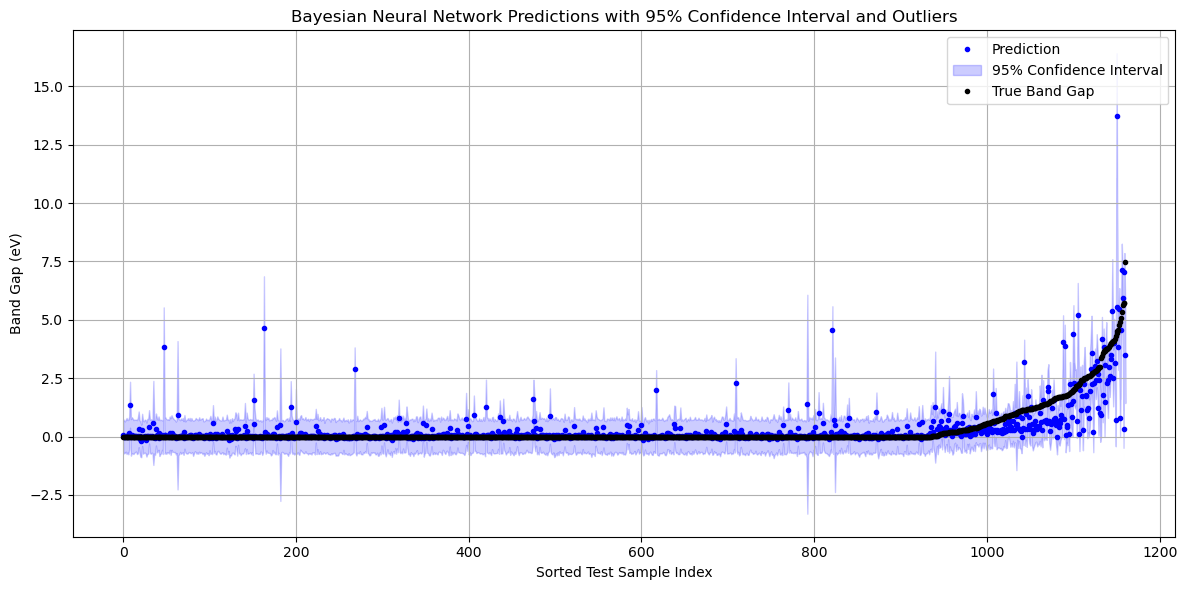

In [28]:
# Define 95% confidence interval bounds (assuming normal distribution)
lower = sorted_mean_pred_actual - 1.96 * sorted_std_pred_actual
upper = sorted_mean_pred_actual + 1.96 * sorted_std_pred_actual

# Compute absolute prediction errors
errors = np.abs(sorted_mean_pred_actual - sorted_y_test_actual)

# Identify outliers with error > 1.5 eV
outlier_mask = errors > 1.5
outlier_indices = np.where(outlier_mask)[0]
outlier_preds = sorted_mean_pred_actual[outlier_indices]

# Map sorted → test → original index
outlier_test_indices = sorted_indices[outlier_indices]
outlier_original_indices = idx_test[outlier_test_indices]

# Get chemical formulas for outliers from original dataframe
formulas = df_mp.iloc[outlier_original_indices]["formula_pretty"].values

# X-axis: just indices of sorted test points
x = np.arange(len(sorted_mean_pred_actual))

# Plot
plt.figure(figsize=(12, 6))

# Mean prediction
plt.plot(x, sorted_mean_pred_actual, 'b.', label="Prediction")

# 95% Confidence interval
plt.fill_between(x, lower, upper, color='blue', alpha=0.2, label="95% Confidence Interval")

# True values
plt.plot(x, sorted_y_test_actual, 'k.', label="True Band Gap")

# Outliers
#plt.scatter(x[outlier_indices], outlier_preds, color='red', edgecolor='black', s=80, label='Outliers')

"""
# Annotate outliers with formula and prediction
for i, idx in enumerate(outlier_indices):
    pred_val = sorted_mean_pred_actual[idx]
    formula = formulas[i]
    plt.annotate(
        f"{formula}\n{pred_val:.2f} eV",
        (x[idx], pred_val),
        textcoords="offset points",
        xytext=(0, 10),
        ha='center',
        fontsize=8,
        color='darkred'
    )
"""

# Formatting
plt.xlabel("Sorted Test Sample Index")
plt.ylabel("Band Gap (eV)")
plt.title("Bayesian Neural Network Predictions with 95% Confidence Interval and Outliers")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
